Reference and complete code adopted by:

https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru/notebook

In [75]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['adaniportshg', 'stock-time-series-20050101-to-20171231']


In a recurrent neural network we store the output activations from one or more of the layers of the network. Often these are hidden later activations. Then, the next time we feed an input example to the network, we include the previously-stored outputs as additional inputs. You can think of the additional inputs as being concatenated to the end of the “normal” inputs to the previous layer. For example, if a hidden layer had 10 regular input nodes and 128 hidden nodes in the layer, then it would actually have 138 total inputs (assuming you are feeding the layer’s outputs into itself à la Elman) rather than into another layer). Of course, the very first time you try to compute the output of the network you’ll need to fill in those extra 128 inputs with 0s or something.

Now, even though RNNs are quite powerful, they suffer from Vanishing gradient problem which hinders them from using long term information, like they are good for storing memory 3-4 instances of past iterations but larger number of instances don't provide good results so we don't just use regular RNNs. Instead, we use a better variation of RNNs: Long Short Term Networks(LSTM).

Vanishing Gradient problem:

Vanishing gradient problem is a difficulty found in training artificial neural networks with gradient-based learning methods and backpropagation. In such methods, each of the neural network's weights receives an update proportional to the partial derivative of the error function with respect to the current weight in each iteration of training. The problem is that in some cases, the gradient will be vanishingly small, effectively preventing the weight from changing its value. In the worst case, this may completely stop the neural network from further training. As one example of the problem cause, traditional activation functions such as the hyperbolic tangent function have gradients in the range (0, 1), and backpropagation computes gradients by the chain rule. This has the effect of multiplying n of these small numbers to compute gradients of the "front" layers in an n-layer network, meaning that the gradient (error signal) decreases exponentially with n while the front layers train very slowly.

Long Short Term Memory(LSTM)

Long short-term memory (LSTM) units (or blocks) are a building unit for layers of a recurrent neural network (RNN). A RNN composed of LSTM units is often called an LSTM network. A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell is responsible for "remembering" values over arbitrary time intervals; hence the word "memory" in LSTM. Each of the three gates can be thought of as a "conventional" artificial neuron, as in a multi-layer (or feedforward) neural network: that is, they compute an activation (using an activation function) of a weighted sum. Intuitively, they can be thought as regulators of the flow of values that goes through the connections of the LSTM; hence the denotation "gate". There are connections between these gates and the cell.

The expression long short-term refers to the fact that LSTM is a model for the short-term memory which can last for a long period of time. An LSTM is well-suited to classify, process and predict time series given time lags of unknown size and duration between important events. LSTMs were developed to deal with the exploding and vanishing gradient problem when training traditional RNNs.

Components of LSTMs:

Forget Gate “f” ( a neural network with sigmoid)

Candidate layer “C"(a NN with Tanh)

Input Gate “I” ( a NN with sigmoid )

Output Gate “O”( a NN with sigmoid)

Hidden state “H” ( a vector )

Memory state “C” ( a vector)

Inputs to the LSTM cell at any step are Xt (current input) , Ht-1 (previous hidden state ) and Ct-1 (previous memory state).

Outputs from the LSTM cell are Ht (current hidden state ) and Ct (current memory state)

I will use LSTMs for predicting the price of stocks of IBM for the year 2017

In [76]:
# importing libraries

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, Bidirectional
from keras.optimizers import SGD

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import math

import warnings
warnings.filterwarnings("ignore")

In [77]:
# function which plots ibm stock prices: real and predicted both

def plot_predictions(test, predicted):
    plt.plot(test, color="red", label="real  stock price")
    plt.plot(predicted, color="blue", label="predicted stock price")
    plt.title("stock price prediction")
    plt.xlabel("time")
    plt.ylabel(" stock price")
    plt.legend()
    plt.show()

In [78]:
# function which calculates root mean squared error

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("the root mean squared error is : {}.".format(rmse))

In [79]:
data = pd.read_csv("/kaggle/input/adaniportshg/ADANIPORTS.csv", index_col='Date', parse_dates=["Date"])

data.shape

(3322, 14)

In [80]:
# Check the columns in the DataFrame
print(data.columns)

# Remove the 'EQ' column
data = data.drop('Series', axis=1)

# Check the columns again
print(data.columns)

Index(['Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last',
       'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble'],
      dtype='object')
Index(['Symbol', 'Prev Close', 'Open', 'High', 'Low', 'Last', 'Close', 'VWAP',
       'Volume', 'Turnover', 'Trades', 'Deliverable Volume', '%Deliverble'],
      dtype='object')


In [81]:
data.head(5)

,Symbol,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,
2007-11-27,MUNDRAPORT,440.00,770.00,1050.00,770.0,959.0,962.90,984.72,27294366,2.687719e+15,NaN,9859619,0.3612
2007-11-28,MUNDRAPORT,962.90,984.00,990.00,874.0,885.0,893.90,941.38,4581338,4.312765e+14,NaN,1453278,0.3172
2007-11-29,MUNDRAPORT,893.90,909.00,914.75,841.0,887.0,884.20,888.09,5124121,4.550658e+14,NaN,1069678,0.2088
2007-11-30,MUNDRAPORT,884.20,890.00,958.00,890.0,929.0,921.55,929.17,4609762,4.283257e+14,NaN,1260913,0.2735
2007-12-03,MUNDRAPORT,921.55,939.75,995.00,922.0,980.0,969.30,965.65,2977470,2.875200e+14,NaN,816123,0.2741


In [82]:
train = data[:'2016'].iloc[:,1:2].values
test = data['2017':].iloc[:,1:2].values

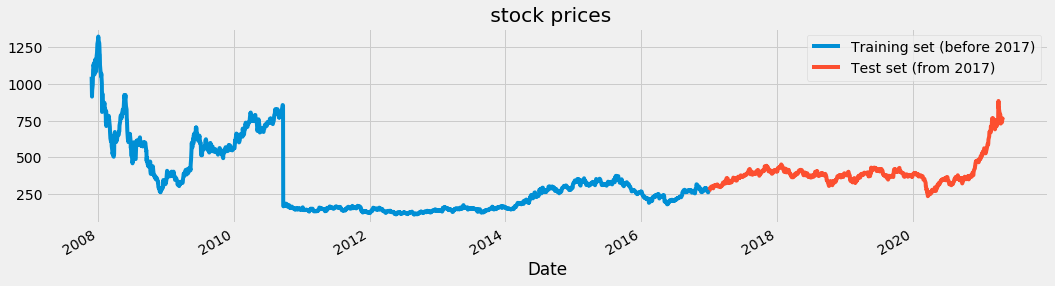

In [83]:
# visualization of "High" attribute of the dataset

data["High"][:'2016'].plot(figsize=(16,4), legend=True)
data["High"]["2017":].plot(figsize=(16,4), legend=True)
plt.legend(["Training set (before 2017)", "Test set (from 2017)"])
plt.title(" stock prices")
plt.show()

In [84]:
# Check the data types of the 'High' attribute
print(data['High'].dtype)

# If it's not already numeric, convert it to numeric
data['High'] = pd.to_numeric(data['High'], errors='coerce')

# Check the data types again
print(data['High'].dtype)

# Now, you can proceed with the scaling
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train)


float64
float64


In [85]:
# scaling the training set

#sc = MinMaxScaler(feature_range=(0,1))
#train_scaled = sc.fit_transform(train)

In [86]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements

x_train = []
y_train = []

for i in range(60, len(train_scaled)):
    x_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [87]:
x_train[0]

array([0.27679353, 0.71274334, 0.65521697, 0.64712993, 0.67826921,
       0.71807912, 0.77823169, 0.81241402, 0.81145525, 0.82904665,
       0.80653633, 0.78340073, 0.77435491, 0.85201551, 0.83579974,
       0.78056609, 0.80616116, 0.79944975, 0.79386385, 0.87440077,
       0.9103339 , 0.92013006, 0.9513527 , 0.9677769 , 0.99116262,
       1.        , 0.97361291, 0.94405769, 0.93313602, 0.91441911,
       0.89395139, 0.8450123 , 0.81524866, 0.77297928, 0.78498478,
       0.76901913, 0.76109884, 0.73917212, 0.59781567, 0.52319813,
       0.62445287, 0.58872817, 0.6317062 , 0.59427237, 0.610905  ,
       0.60231773, 0.60832048, 0.59806578, 0.62370253, 0.60552753,
       0.58318396, 0.57380466, 0.56363333, 0.50289716, 0.47796907,
       0.46934011, 0.50172996, 0.51752887, 0.55325357, 0.54683397])

In [88]:
y_train[0]

0.5203218141648255

In [89]:
len(x_train)

2191

In [90]:
len(y_train)

2191

In [91]:
x_train.shape

(2191, 60)

In [92]:
y_train.shape

(2191,)

In [93]:
# reshaping x_train for efficient modelling

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [94]:
x_train.shape

(2191, 60, 1)

In [95]:
dataset_total = pd.concat((data['High'][:'2016'], data['High']['2017':]), axis=0)
inputs = dataset_total[len(dataset_total)-len(test)-60 : ].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [96]:
# preparing x_test

x_test = []
for i in range(60,311):
    x_test.append(inputs[i-60:i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

Gated Recurrent Units

In simple words, the GRU unit does not have to use a memory unit to control the flow of information like the LSTM unit. It can directly makes use of the all hidden states without any control. GRUs have fewer parameters and thus may train a bit faster or need less data to generalize. But, with large data, the LSTMs with higher expressiveness may lead to better results.

They are almost similar to LSTMs except that they have two gates: reset gate and update gate. Reset gate determines how to combine new input to previous memory and update gate determines how much of the previous state to keep. Update gate in GRU is what input gate and forget gate were in LSTM. We don't have the second non linearity in GRU before calculating the output, .neither they have the output gate.

In [97]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))

In [98]:
# compiling the model

regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False), loss='mean_squared_error')

# fitting the model

regressorGRU.fit(x_train, y_train, epochs=5, batch_size=150)

Epoch 1/5
2191/2191 [==============================] - 8s 4ms/step - loss: 0.0420
Epoch 2/5
2191/2191 [==============================] - 5s 2ms/step - loss: 0.0275
Epoch 3/5
2191/2191 [==============================] - 5s 2ms/step - loss: 0.0208
Epoch 4/5
2191/2191 [==============================] - 5s 2ms/step - loss: 0.0146
Epoch 5/5
2191/2191 [==============================] - 5s 2ms/step - loss: 0.0090


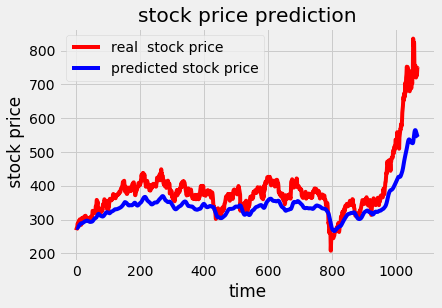

the root mean squared error is : 62.65847331590434.


In [99]:
# Assuming len(test) is the correct length of your test set
# Adjust the range accordingly to match the length of your test set
x_test = np.array([inputs[i-60:i, 0] for i in range(60, len(test) + 60)])

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# predicting the stock prices for the test set
predicted_with_gru = regressorGRU.predict(x_test)
predicted_with_gru = sc.inverse_transform(predicted_with_gru)

# visualizing the results: predicted vs test
plot_predictions(test, predicted_with_gru)

# evaluating the model performance
return_rmse(test, predicted_with_gru)


In [100]:
# evaluating the model performance

return_rmse(test, predicted_with_gru)

the root mean squared error is : 62.65847331590434.


Thanks if you find it useful! :)